In [35]:
import pandas as pd
import json
import requests
#from config import api_key
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt


In [36]:
# Save config information
url = "https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/super-bowl@public/records?limit=54"


In [37]:
super_bowl_url = requests.get(url)
super_bowl_data = super_bowl_url.json()
pprint(super_bowl_data)


{'results': [{'attendance': 80562,
              'back_judge': None,
              'city': 'New Orleans',
              'coach_loser': 'Bud Grant',
              'coach_winner': 'Hank Stram',
              'date': '1970-01-11',
              'field_judge': None,
              'geo_point_2d': {'lat': 31.0480777894, 'lon': -91.9572061819},
              'geo_shape': {'geometry': {'coordinates': [[[-89.21767, 29.29108],
                                                          [-89.4083872139,
                                                           29.1597708196],
                                                          [-89.77928, 29.30714],
                                                          [-90.15463, 29.11743],
                                                          [-90.880225,
                                                           29.148535],
                                                          [-91.626785, 29.677],
                                             

In [38]:

results = super_bowl_data.get("results", [])
super_bowl_history_df = pd.DataFrame(results)
super_bowl_history_df.head()

,date,sb,attendance,winner,qb_winner,coach_winner,winning_pts,loser,qb_loser,coach_loser,...,point_difference,referee,umpire,head_linesman,line_judge,field_judge,back_judge,side_judge,geo_shape,geo_point_2d
0,1970-01-11,IV,80562,Kansas City Chiefs,"Len Dawson, Mike Livingston",Hank Stram,23,Minnesota Vikings,Joe Kapp,Bud Grant,...,16,None,None,None,None,None,None,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -91.9572061819, 'lat': 31.0480777894}"
1,1993-01-31,XXVII,98374,Dallas Cowboys,Troy Aikman,Jimmy Johnson,52,Buffalo Bills,"Jim Kelly, Frank Reich",Marv Levy,...,35,Dick Hantak,Ron Botchan,Ron Phares,Dick McKenzie,Donnie Hampton,Jim Poole,Dean Look,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -119.640543961, 'lat': 37.2551445335}"
2,1999-01-31,XXXIII,74803,Denver Broncos,John Elway,Mike Shanahan,34,Atlanta Falcons,Chris Chandler,Dan Reeves,...,15,Bernie Kukar,Jim Daopoulos,Sanford Rivers,Ron Baynes,Tim Millis,Don Hakes,Gary Lane,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -82.5025741003, 'lat': 28.6169283051}"
3,2018-02-04,LII,67612,Philadelphia Eagles,Nick Foles,Doug Pederson,41,New England Patriots,Tom Brady,Bill Belichick,...,8,Gene Steratore,Roy Ellison,Jerry Bergman,Byron Boston,Tom Hill,Perry Paganelli,Scott Edwards,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -94.1774361191, 'lat': 46.3600731634}"
4,1991-01-27,XXV,73813,New York Giants,Jeff Hostetler,Bill Parcells,20,Buffalo Bills,Jim Kelly,Marv Levy,...,1,Jerry Seeman,Art Demmas,Sid Semon,Dick McKenzie,Jack Vaughan,Banks Williams,Larry Nemmers,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -82.5025741003, 'lat': 28.6169283051}"


In [39]:
super_bowl_history_df['date'] = pd.to_datetime(super_bowl_history_df['date'])
super_bowl_history_df.sort_values(by='date', ascending=True, inplace=True)
super_bowl_history_df.reset_index(drop=True, inplace=True)
super_bowl_history_df.head()

,date,sb,attendance,winner,qb_winner,coach_winner,winning_pts,loser,qb_loser,coach_loser,...,point_difference,referee,umpire,head_linesman,line_judge,field_judge,back_judge,side_judge,geo_shape,geo_point_2d
0,1967-01-15,I,61946,Green Bay Packers,Bart Starr,Vince Lombardi,35,Kansas City Chiefs,Len Dawson,Hank Stram,...,25,None,None,None,None,None,None,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -119.640543961, 'lat': 37.2551445335}"
1,1968-01-14,II,75546,Green Bay Packers,Bart Starr,Vince Lombardi,33,Oakland Raiders,Daryle Lamonica,John Rauch,...,19,None,None,None,None,None,None,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -82.5025741003, 'lat': 28.6169283051}"
2,1969-01-12,III,75389,New York Jets,Joe Namath,Weeb Ewbank,16,Baltimore Colts,"Earl Morrall, Johnny Unitas",Don Shula,...,9,None,None,None,None,None,None,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -82.5025741003, 'lat': 28.6169283051}"
3,1970-01-11,IV,80562,Kansas City Chiefs,"Len Dawson, Mike Livingston",Hank Stram,23,Minnesota Vikings,Joe Kapp,Bud Grant,...,16,None,None,None,None,None,None,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -91.9572061819, 'lat': 31.0480777894}"
4,1971-01-17,V,79204,Baltimore Colts,"Earl Morrall , Johnny Unitas",Don McCafferty,16,Dallas Cowboys,Craig Morton,Tom Landry,...,3,Norm Schachter,Paul Trepinski,Ed Marion,Jack Fette,Fritz Graf,Hugh Gamber,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -82.5025741003, 'lat': 28.6169283051}"


In [40]:
drop_columns = ["referee", "umpire", "head_linesman", "line_judge", 
                "field_judge", "back_judge", "side_judge", "qb_winner",
                "coach_winner", "winning_pts", "qb_loser", "coach_loser",
                "losing_pts", "mvp","point_difference","geo_shape","geo_point_2d"]
super_bowl_history_df.drop(columns=drop_columns, inplace=True)
super_bowl_history_df.head()

,date,sb,attendance,winner,loser,stadium,city,state
0,1967-01-15,I,61946,Green Bay Packers,Kansas City Chiefs,Memorial Coliseum,Los Angeles,California
1,1968-01-14,II,75546,Green Bay Packers,Oakland Raiders,Orange Bowl,Miami,Florida
2,1969-01-12,III,75389,New York Jets,Baltimore Colts,Orange Bowl,Miami,Florida
3,1970-01-11,IV,80562,Kansas City Chiefs,Minnesota Vikings,Tulane Stadium,New Orleans,Louisiana
4,1971-01-17,V,79204,Baltimore Colts,Dallas Cowboys,Orange Bowl,Miami,Florida


In [41]:
sb_views = "Resources/SBtv.csv"

views_df = pd.read_csv(sb_views)

views_df = views_df.sort_values(by="super_bowl", ascending=True) 
views_df = views_df.drop_duplicates(subset="super_bowl", keep="first")
views_df = views_df.reset_index(drop=True)
views_extract = views_df["avg_us_viewers"]

views_df.head()

,super_bowl,network,avg_us_viewers,total_us_viewers,rating_household,share_household,rating_18_49,share_18_49,ad_cost
0,1,NBC,24430000,NaN,18.5,36,NaN,NaN,37500
1,2,CBS,39120000,NaN,36.8,68,NaN,NaN,54500
2,3,NBC,41660000,NaN,36.0,70,NaN,NaN,55000
3,4,CBS,44270000,NaN,39.4,69,NaN,NaN,78200
4,5,NBC,46040000,NaN,39.9,75,NaN,NaN,72500


In [42]:
final_df = pd.merge(super_bowl_history_df, views_extract, how="left", left_index=True, right_index=True)
final_df = final_df.rename(columns={"date": "Date", "sb": "Super Bowl", "attendance": "Attendance", 
                        "winner": "Winning Team", "loser": "Losing Team", "stadium": "Stadium", 
                        "city": "City", "state": "State", "avg_us_viewers": "Average US Viewership"})
final_df = final_df.reset_index(drop=True)
final_df.head()



,Date,Super Bowl,Attendance,Winning Team,Losing Team,Stadium,City,State,Average US Viewership
0,1967-01-15,I,61946,Green Bay Packers,Kansas City Chiefs,Memorial Coliseum,Los Angeles,California,24430000
1,1968-01-14,II,75546,Green Bay Packers,Oakland Raiders,Orange Bowl,Miami,Florida,39120000
2,1969-01-12,III,75389,New York Jets,Baltimore Colts,Orange Bowl,Miami,Florida,41660000
3,1970-01-11,IV,80562,Kansas City Chiefs,Minnesota Vikings,Tulane Stadium,New Orleans,Louisiana,44270000
4,1971-01-17,V,79204,Baltimore Colts,Dallas Cowboys,Orange Bowl,Miami,Florida,46040000


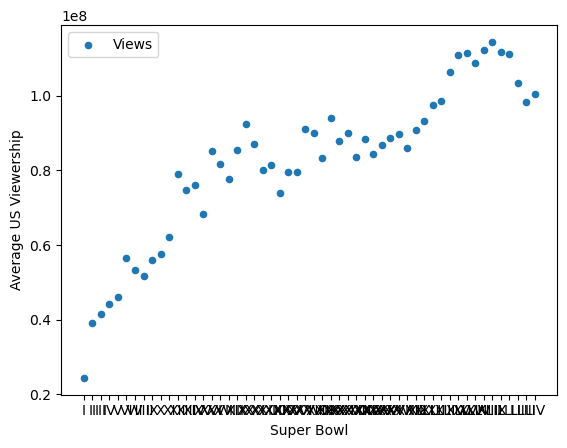

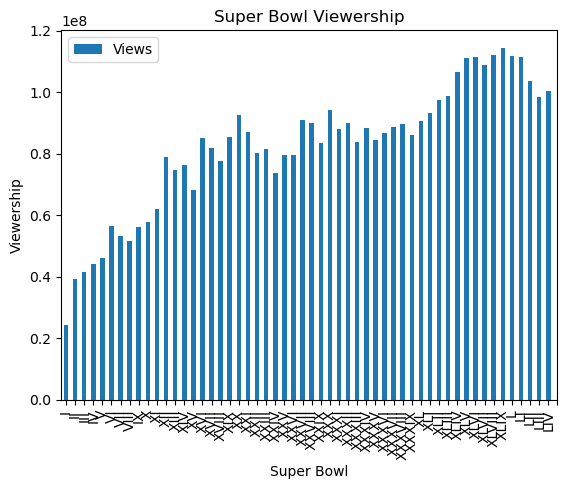

<Figure size 2000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [46]:
final_df.plot(kind="scatter", x="Super Bowl", y="Average US Viewership", label= "Views")
final_df.plot(kind="bar", x="Super Bowl", y="Average US Viewership", label= "Views")

plt.title("Super Bowl Viewership")
plt.xlabel("Super Bowl")
plt.ylabel("Viewership")
plt.xticks(range(0,55))
plt.figure(figsize=(20,4))
plt.show()
plt.tight_layout()


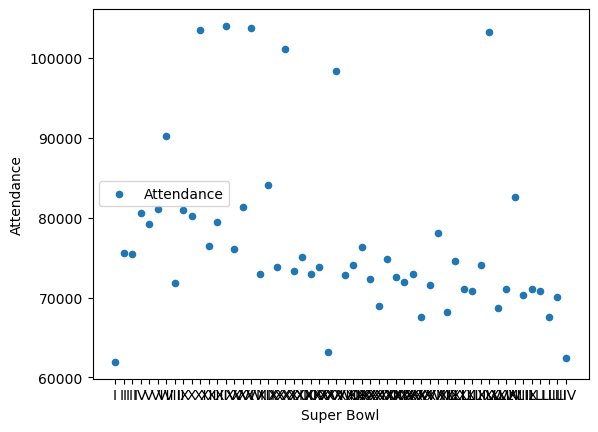

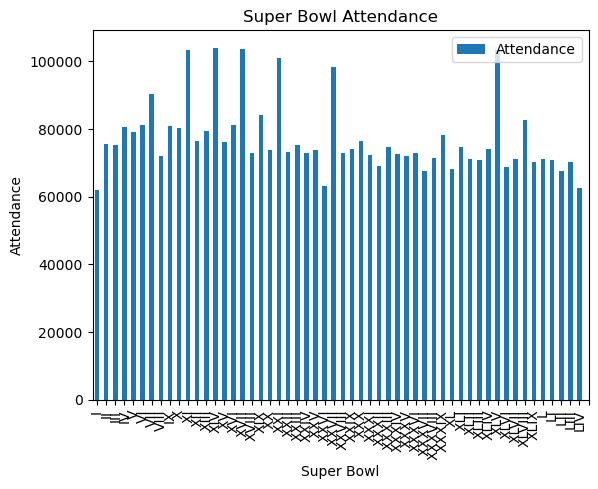

<Figure size 2000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [48]:
final_df.plot(kind="scatter", x="Super Bowl", y="Attendance", label= "Attendance")
final_df.plot(kind="bar", x="Super Bowl", y="Attendance", label= "Attendance")

plt.title("Super Bowl Attendance")
plt.xlabel("Super Bowl")
plt.ylabel("Attendance")
plt.xticks(range(0,55))
plt.figure(figsize=(20,4))
plt.show()
plt.tight_layout()